In [1]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [2]:
import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

model_id = "timbrooks/instruct-pix2pix"
pipe = StableDiffusionInstructPix2PixPipeline.from_pretrained(model_id, torch_dtype=torch.float16, safety_checker=None)
pipe.to("cuda")
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)


image = PIL.Image.open("/workspace/mvs_training/dtu/Rectified/scan126_train/rect_001_0_r5000.png")

/workspace/viewdiff/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 6/6 [00:02<00:00,  2.13it/s]


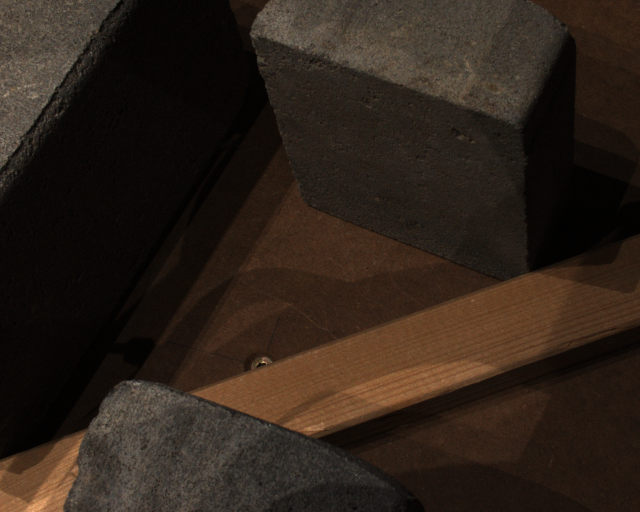

In [26]:
image

 30%|███       | 3/10 [00:00<00:00,  9.97it/s]

100%|██████████| 10/10 [00:00<00:00, 10.51it/s]


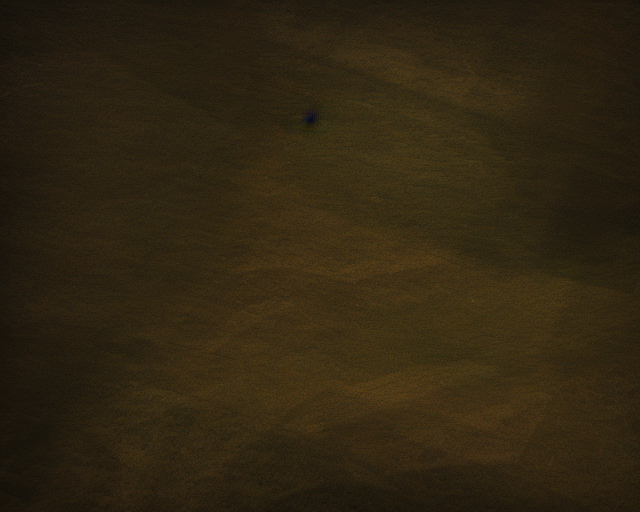

In [31]:





prompt = "remove the left stone"
images = pipe(prompt, image=image, num_inference_steps=10, image_guidance_scale=1).images
images[0]



In [2]:
import PIL
import requests
import torch
from diffusers import StableDiffusionInstructPix2PixPipeline, EulerAncestralDiscreteScheduler

In [3]:
# import unet,textencoder,tokenizer,scheduler
from transformers import CLIPTokenizer, CLIPTextModel, CLIPVisionModel
from diffusers import AutoencoderKL,UNet2DConditionModel,DDPMScheduler

In [4]:
def load_models(pretrained_model_name_or_path: str, revision: str = None):
    noise_scheduler = EulerAncestralDiscreteScheduler.from_pretrained(pretrained_model_name_or_path, subfolder="scheduler", 
                                                                      rescale_betas_zero_snr=True)
    tokenizer = CLIPTokenizer.from_pretrained(pretrained_model_name_or_path, subfolder="tokenizer", revision=revision)
    text_encoder = CLIPTextModel.from_pretrained(pretrained_model_name_or_path, subfolder="text_encoder", revision=revision)
    vae = AutoencoderKL.from_pretrained(pretrained_model_name_or_path, subfolder="vae", revision=revision)
    unet = UNet2DConditionModel.from_pretrained(pretrained_model_name_or_path, subfolder="unet", revision=revision)

    return noise_scheduler, tokenizer, text_encoder, vae, unet


In [5]:
model_id = "timbrooks/instruct-pix2pix"
scheduelr, tokenizer, text_encoder, vae, unet = load_models(model_id)

# update model

## define config

In [6]:
from dataclasses import dataclass, asdict
from typing import Literal, List, Optional, Union, Dict

In [7]:
@dataclass
class ModelConfig:
    """Arguments for model."""

    n_input_images: int = 3
    """How many images are expected as input in parallel."""

    pose_cond_mode: Literal["none", "ca", "sa-ca", "sa-ca-cfa", "ca-cfa"] = "none"
    """How to add the pose conditioning to the attention layers of the U-Net.
        "none": do not add any pose-conditioning.
        "ca": add it only to cross-attention (to text) layers.
        "sa-ca": add it to self-attention and cross-attention layers.
        "sa-ca-cfa: add it to self-attention, cross-attention, and cross-frame-attention layers.
        "ca-cfa": add it to cross-attention and cross-frame-attention layers.
    """

    pose_cond_coord_space: Literal["absolute", "relative-first"] = "absolute"
    """How to encode the pose conditioning.
        "absolute": encode poses like in Zero123, but relative to the world-space-origin.
        "relative-first": encode poses like in Zero123, where the first pose in each batch is the conditioning pose.
    """

    pose_cond_lora_rank: int = 4
    """rank of the lora matrices used for the pose conditioning."""

    pose_cond_dim: int = 10
    """How many things we provide as pose conditioning. Currently it is 4 values for extrinsics (as in Zero123) + 4 values for intrinsics + 2 values for mean/var image intensity."""

    conditioning_dropout_prob: float = 0.1
    """Conditioning dropout probability. Drops out the conditionings (text prompt) used in training."""

    use_ema: bool = False
    """Whether to use EMA model."""

    enable_xformers_memory_efficient_attention: bool = True
    """Whether or not to use xformers."""

    gradient_checkpointing: bool = False
    """Whether or not to use gradient checkpointing to save memory at the expense of slower backward pass."""



In [8]:
@dataclass
class OptimizerConfig:
    """Arguments for optimizer"""

    learning_rate: float = 5e-5
    """Initial learning rate (after the potential warmup period) to use."""

    vol_rend_learning_rate: float = 1e-3
    """Initial learning rate (after the potential warmup period) to use for the volume-rendering components in the model."""

    vol_rend_adam_weight_decay: float = 0.0
    """Weight decay to use for the volume-rendering components in the model."""

    scale_lr: bool = False
    """Scale the learning rate by the number of GPUs, gradient accumulation steps, and batch size."""

    lr_scheduler: Literal[
        "linear", "cosine", "cosine_with_restarts", "polynomial", "constant", "constant_with_warmup"
    ] = "constant"
    """The scheduler type to use."""

    lr_warmup_steps: int = 500
    """Number of steps for the warmup in the lr scheduler."""

    use_8bit_adam: bool = False
    """Whether or not to use 8-bit Adam from bitsandbytes."""

    allow_tf32: bool = False
    """Whether or not to allow TF32 on Ampere GPUs. Can be used to speed up training. For more information, see
        https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices"""

    adam_beta1: float = 0.9
    """The beta1 parameter for the Adam optimizer."""

    adam_beta2: float = 0.999
    """The beta2 parameter for the Adam optimizer."""

    adam_weight_decay: float = 1e-2
    """Weight decay to use."""

    adam_epsilon: float = 1e-08
    """Epsilon value for the Adam optimizer"""

    max_grad_norm: float = 0.1
    """Max gradient norm."""

    gradient_accumulation_steps: int = 1
    """Number of updates steps to accumulate before performing a backward/update pass."""

    only_train_new_layers: bool = False
    """If set, will only optimize over new layers (e.g. additional cross-frame attention layers)."""


In [9]:
@dataclass
class TrainingConfig:
    """Arguments for training."""

    validation_epochs: int = 1
    """Run fine-tuning validation every X epochs."""

    train_batch_size: int = 1
    """Batch size (per device) for the training dataloader."""

    num_train_epochs: int = 500
    """epochs"""

    max_train_steps: Optional[int] = None
    """Total number of training steps to perform.  If provided, overrides num_train_epochs."""

    dataloader_num_workers: int = 4
    """Number of subprocesses to use for data loading. 0 means that the data will be loaded in the main process."""

    local_rank: int = -1
    """For distributed training: local_rank"""

    mixed_precision: Optional[Literal["no", "fp16", "bf16"]] = None
    """Whether to use mixed precision. Choose between fp16 and bf16 (bfloat16). Bf16 requires PyTorch >= 1.10.
       and an Nvidia Ampere GPU.  Default to the value of accelerate config of the current system or the
        flag passed with the `accelerate.launch` command. Use this argument to override the accelerate config."""

    noise_prediction_type: Literal["epsilon", "v_prediction", "sample"] = "epsilon"
    """How to calculate the diffusion denoising MSE loss. The target is the applied noise ('epsilon'), the noise-free sample ('sample'), or the velocity ('v_prediction')."""

    remove_cfa_skip_connections_at_iter: int = -1
    """If >-1, it will change the last_layer_mode in all cross-frame-attention transformer-blocks to --changed_cfa_last_layer after that many training iterations."""

    changed_cfa_last_layer: Literal["none", "no_residual_connection"] = "no_residual_connection"
    """Change the last_layer_mode in all cross-frame-attention transformer-blocks to this value."""

    dreambooth_prior_preservation_loss_weight: float = 0.0
    """If >0, will use prior preservation loss during training similar to Dreambooth (see https://dreambooth.github.io/)."""

    dreambooth_prior_preservation_every_nth: int = 5
    """Calculates the prior preservation loss every nth step."""

    prob_images_not_noisy: float = 0.25
    """With this probability, some of the images in a batch will be not noisy (e.g. input image conditioning)."""

    max_num_images_not_noisy: int = 2
    """If some of the images in a batch should not be noisy: this defines the maximum number of images to which this applies."""



In [10]:
@dataclass
class SaveConfig:
    """Which file types should be saved in #save_inference_outputs()."""

    image_grids: bool = False
    pred_files: bool = True
    pred_video: bool = True
    pred_gif: bool = False
    denoise_files: bool = False
    denoise_video: bool = False
    cams: bool = True
    prompts: bool = True
    rendered_depth: bool = False
    cond_files: bool = False
    image_metrics: bool = True

@dataclass
class IOConfig:
    """Arguments for IO."""

    save: SaveConfig = SaveConfig()

    pretrained_model_name_or_path: str = "stabilityai/stable-diffusion-2-1-base",
    """Path to pretrained model or model identifier from huggingface.co/models"""

    revision: Optional[str] = None
    """Revision of pretrained model identifier from huggingface.co/models."""

    output_dir: str = "output"
    """The output directory where the model predictions and checkpoints will be written."""

    experiment_name: Optional[str] = None
    """If this is set, will use this instead of the datetime string as identifier for the experiment."""

    logging_dir: str = "logs"
    """[TensorBoard](https://www.tensorflow.org/tensorboard) log directory. Will default to
        *output_dir/runs/**CURRENT_DATETIME_HOSTNAME***."""

    log_images_every_nth: int = 500
    """log images every nth step"""

    report_to: Literal["tensorboard", "custom_tensorboard"] = "custom_tensorboard"
    """The integration to report the results and logs to. Supported platforms are `"tensorboard"`"""

    checkpointing_steps: int = 500
    """Save a checkpoint of the training state every X updates. These checkpoints are only suitable for resuming
        training using `--resume_from_checkpoint`."""

    checkpoints_total_limit: int = 2
    """Max number of checkpoints to store."""

    resume_from_checkpoint: Optional[str] = None
    """Whether training should be resumed from a previous checkpoint. Use a path saved by
        ' `--checkpointing_steps`, or `"latest"` to automatically select the last available checkpoint."""

    automatic_checkpoint_resume: bool = False

In [11]:
@dataclass
class CrossFrameAttentionConfig:
    mode: Literal["none", "pretrained", "add_in_existing_block"] = "none"
    """How to add cross-frame attention to the U-Net
        "none": do not add cross-frame attention.
        "pretrained": add cross-frame attention in the existing self-attention layers of the U-Net.
        "add_in_existing_block": add cross-frame attention by inserting a new attention layer in each BasicTransformerBlock.
    """

    n_cfa_down_blocks: int = 1
    """How many of the down_blocks in the U-Net should be replaced with blocks that contain cross-frame-attention."""

    n_cfa_up_blocks: int = 1
    """How many of the up_blocks in the U-Net should be replaced with blocks that contain cross-frame-attention."""

    no_cfa_in_mid_block: bool = False
    """If we should not use cross-frame-attention in the mid_block. Default behaviour: use it as soon as mode!=none. This forcibly overrides the setting."""

    to_k_other_frames: int = 2
    """How many of the other images in a batch to use as key/value."""

    with_self_attention: bool = False
    """If the key/value of the query image should be appended. Only relevant for mode='pretrained'."""

    random_others: bool = False
    """If True, will select the k_other_frames randomly, otherwise sequentially."""

    last_layer_mode: Literal["none", "zero-conv", "alpha", "no_residual_connection"] = "zero-conv"
    """How to add the contributions of cross-frame-attention.
        'none': directly add them to the residual connection in the ViT blocks.
        'zero-conv': add them with the zero-conv idea from ControlNet.
        'alpha': add them with the alpha idea from VideoLDM.
        'no_residual_connection': do not use residual connection, instead use the output directly."""

    unproj_reproj_mode: Literal["none", "only_unproj_reproj", "with_cfa"] = "none"
    """How to use unproj_reproj as layer in the model.
        "none": do not use the layer.
        "only_unproj_reproj": use the layer instead of cross-frame-attention.
        "with_cfa": use the layer in addition to cross-frame-attention.
    """

    num_3d_layers: int = 1
    """how many 3D layers to use in the 3D CNN."""

    dim_3d_latent: int = 32
    """dimension of the 3D latent features to process with the 3D CNN."""

    dim_3d_grid: int = 64
    """dimension of the 3D voxel grid to process with the 3D CNN."""

    vol_rend_proj_in_mode: Literal["single", "multiple", "unet"] = "unet"
    """How to convert hidden states into features for our proj-module.
        'single': a single 1x1 convolution is used
        'multiple': 2x{Conv_3x3, Relu} is used
        'unet': a 3-layer unet is used"""

    vol_rend_proj_out_mode: Literal["single", "multiple"] = "multiple"
    """How to convert projected features into hidden states after our proj-module. We always use a linear combination of foreground and background.
    For the background, we always use a single Conv_1x1. For the foreground we use either:
    'single': a single 1x1 convolution
    'multiple': 2x{Conv_1x1, Relu} followed by Conv_1x1 (==learned non-linear scale function)"""

    vol_rend_aggregator_mode: Literal["mean", "ibrnet"] = "ibrnet"
    """How to convert per-frame voxel grids into a joint voxel-grid across all frames.
    'mean': mean across each voxel in each frame.
    'ibrnet': use the aggregator as proposed in IBRNet (https://arxiv.org/abs/2102.13090)"""

    vol_rend_model_background: bool = False
    """If the volume-rendering module should model the background."""

    vol_rend_background_grid_percentage: float = 0.5
    """How much of the voxel grid should be used for background, if we need to model it."""

    vol_rend_disparity_at_inf: float = 0.5
    """The value for disparity_at_inf argument for the volume-rendering module."""

    n_novel_images: int = 1
    """during unprojection, how many images to consider novel. They are not used for unprojection, but only for reprojection (novel-view-synthesis)."""

    use_temb_cond: bool = True
    """If True, will use timestep embedding as additional input for cross-frame-attention and projection layers. Useful to process a batch with images of different timesteps."""


In [12]:
@dataclass
class FinetuneConfig:
    training: TrainingConfig
    optimizer: OptimizerConfig
    model: ModelConfig
    cross_frame_attention: CrossFrameAttentionConfig
    io: IOConfig


# define transformerblock

# define Unet model

In [13]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

from typing import Optional, List, Dict

import os
import tyro
import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint

from accelerate import Accelerator, skip_first_batches
from accelerate.logging import get_logger
from tqdm.auto import tqdm

from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import (
    AutoencoderKL,
    DDPMScheduler,
    UNet2DConditionModel,
    DPMSolverMultistepScheduler,
)
import sys
import os
sys.path.append("/root/autodl-tmp/ViewDiff/")
from viewdiff.model.custom_unet_2d_condition import (
    UNet2DConditionCrossFrameInExistingAttnModel,
    get_down_block_types,
    get_mid_block_type,
    get_up_block_types,
)
from viewdiff.model.util import (
    replace_self_attention_with_cross_frame_attention,
    update_last_layer_mode,
    update_vol_rend_inject_noise_sigma,
    update_n_novel_images,
    update_cross_frame_attention_config,
    add_pose_cond_to_attention_layers,
    collapse_prompt_to_batch_dim,
    collapse_tensor_to_batch_dim,
    expand_output_to_k,
    expand_tensor_to_k,
    tokenize_captions,
    ModelConfig,
    CrossFrameAttentionConfig,
    build_cross_attention_kwargs,
)
from viewdiff.model.custom_stable_diffusion_pipeline import CustomStableDiffusionPipeline

from viewdiff.io_util import (
    make_image_grid,
    norm_0_1,
    setup_output_directories,
    make_output_directories,
    save_inference_outputs,
    IOConfig,
)
from viewdiff.train_util import (
    check_local_rank,
    FinetuneConfig,
    load_models,
    setup_accelerate,
    setup_model_and_optimizer,
    setup_train_val_dataloaders,
    setup_training,
    save_checkpoint,
    maybe_continue_training,
)

from viewdiff.metrics.image_metrics import calc_psnr_ssim_lpips

from viewdiff.data.co3d.co3d_dataset import CO3DConfig

from viewdiff.scripts.misc.create_masked_images import remove_background


logger = get_logger(__name__, log_level="INFO")



/root/autodl-tmp/ViewDiff/viewdiff


In [14]:
finetuneconfig = FinetuneConfig(TrainingConfig(), OptimizerConfig(), ModelConfig(), CrossFrameAttentionConfig(), IOConfig())

In [15]:
def update_model(finetune_config: FinetuneConfig, unet: UNet2DConditionModel):
    if finetune_config.cross_frame_attention.mode != "none":
        use_lora_in_cfa = "cfa" in finetune_config.model.pose_cond_mode
        if (
            finetune_config.cross_frame_attention.mode == "pretrained"
            or finetune_config.cross_frame_attention.mode == "add_in_existing_block"
        ):
            # if finetune_config.cross_frame_attention.mode == "pretrained":
            #     # overwrite the settings for cfa to not create the cfa layers
            #     # instead we want to re-use the sa layers for it
            #     if finetune_config.cross_frame_attention.unproj_reproj_mode == "with_cfa":
            #         finetune_config.cross_frame_attention.unproj_reproj_mode = "only_unproj_reproj"

            unet = UNet2DConditionCrossFrameInExistingAttnModel.from_source(
                src=unet,
                load_weights=True,
                down_block_types=get_down_block_types(finetune_config.cross_frame_attention.n_cfa_down_blocks),
                mid_block_type=get_mid_block_type(not finetune_config.cross_frame_attention.no_cfa_in_mid_block),
                up_block_types=get_up_block_types(finetune_config.cross_frame_attention.n_cfa_up_blocks),
                n_input_images=finetune_config.model.n_input_images,
                to_k_other_frames=finetune_config.cross_frame_attention.to_k_other_frames,
                random_others=finetune_config.cross_frame_attention.random_others,
                last_layer_mode=finetune_config.cross_frame_attention.last_layer_mode,
                use_lora_in_cfa=use_lora_in_cfa,
                use_temb_in_lora=finetune_config.cross_frame_attention.use_temb_cond,
                temb_out_size=8,
                pose_cond_dim=finetune_config.model.pose_cond_dim,
                rank=finetune_config.model.pose_cond_lora_rank,
                unproj_reproj_mode=finetune_config.cross_frame_attention.unproj_reproj_mode,
                dim_3d_grid=finetune_config.cross_frame_attention.dim_3d_grid,
                dim_3d_latent=finetune_config.cross_frame_attention.dim_3d_latent,
                n_novel_images=finetune_config.cross_frame_attention.n_novel_images,
                num_3d_layers=finetune_config.cross_frame_attention.num_3d_layers,
                vol_rend_proj_in_mode=finetune_config.cross_frame_attention.vol_rend_proj_in_mode,
                vol_rend_aggregator_mode=finetune_config.cross_frame_attention.vol_rend_aggregator_mode,
                vol_rend_proj_out_mode=finetune_config.cross_frame_attention.vol_rend_proj_out_mode,
                vol_rend_model_background=finetune_config.cross_frame_attention.vol_rend_model_background,
                vol_rend_background_grid_percentage=finetune_config.cross_frame_attention.vol_rend_background_grid_percentage,
                vol_rend_disparity_at_inf=finetune_config.cross_frame_attention.vol_rend_disparity_at_inf,
            )

            if finetune_config.cross_frame_attention.mode == "pretrained":
                # TODO: allow to only replace the layers as specified in finetune_config.cross_frame_attention.n_cfa_down_blocks
                replace_self_attention_with_cross_frame_attention(
                    unet=unet,
                    n_input_images=finetune_config.model.n_input_images,
                    to_k_other_frames=finetune_config.cross_frame_attention.to_k_other_frames,
                    with_self_attention=finetune_config.cross_frame_attention.with_self_attention,
                    random_others=finetune_config.cross_frame_attention.random_others,
                    use_lora_in_cfa=use_lora_in_cfa or "sa" in finetune_config.model.pose_cond_mode,
                    use_temb_in_lora=finetune_config.cross_frame_attention.use_temb_cond,
                    temb_out_size=8,
                    pose_cond_dim=finetune_config.model.pose_cond_dim,
                    rank=finetune_config.model.pose_cond_lora_rank,
                )
        else:
            raise NotImplementedError(
                "unsupported cross_frame_attention.mode", finetune_config.cross_frame_attention.mode
            )

    unet_lora_parameters = None
    if finetune_config.model.pose_cond_mode != "none":
        # Set correct lora layers
        unet_lora_attn_procs, unet_lora_parameters = add_pose_cond_to_attention_layers(
            unet,
            rank=finetune_config.model.pose_cond_lora_rank,
            pose_cond_dim=finetune_config.model.pose_cond_dim,
            only_cross_attention="sa" not in finetune_config.model.pose_cond_mode,
        )

    return unet, unet_lora_parameters

In [16]:
finetuneconfig.io.pretrained_model_name_or_path =  model_id
finetuneconfig.io.output_dir= "/root/autodl-tmp/ViewDiff/output"
finetuneconfig.io.experiment_name=" train_teddybear"
finetuneconfig.training.mixed_precision = "no"
finetuneconfig.training.dataloader_num_workers= 4
finetuneconfig.training.num_train_epochs = 1000
finetuneconfig.training.train_batch_size =  1
finetuneconfig.training.dreambooth_prior_preservation_loss_weight=-1
finetuneconfig.training.noise_prediction_type =  "epsilon"
finetuneconfig.training.prob_images_not_noisy= 0.25
finetuneconfig.training.max_num_images_not_noisy= 2,
finetuneconfig.training.validation_epochs= 1
finetuneconfig.training.dreambooth_prior_preservation_every_nth=-1
finetuneconfig.optimizer.learning_rate=5e-5
finetuneconfig.optimizer.vol_rend_learning_rate =1e-3
finetuneconfig.optimizer.vol_rend_adam_weight_decay = 0.0
finetuneconfig.optimizer.gradient_accumulation_steps =  1
finetuneconfig.optimizer.max_grad_norm = 5e-3
finetuneconfig.cross_frame_attention.to_k_other_frames =  2

finetuneconfig.cross_frame_attention.mode ="pretrained"
finetuneconfig.cross_frame_attention.n_cfa_down_blocks = 1
finetuneconfig.cross_frame_attention.n_cfa_up_blocks= 1
finetuneconfig.cross_frame_attention.unproj_reproj_mode = "with_cfa"

finetuneconfig.model.pose_cond_mode ="sa-ca"
finetuneconfig.model.pose_cond_coord_space = "absolute"
finetuneconfig.model.pose_cond_lora_rank = 64
finetuneconfig.model.n_input_images =3


In [17]:
unet, unet_lora_parameters = update_model(finetuneconfig, unet)

In [18]:

def _encode_prompt(
        
        prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt=None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
    ):
        r"""
        Encodes the prompt into text encoder hidden states.

        Args:
             prompt (`str` or `List[str]`, *optional*):
                prompt to be encoded
            device: (`torch.device`):
                torch device
            num_images_per_prompt (`int`):
                number of images that should be generated per prompt
            do_classifier_free_guidance (`bool`):
                whether to use classifier free guidance or not
            negative_ prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            negative_prompt_embeds (`torch.FloatTensor`, *optional*):
                Pre-generated negative text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt
                weighting. If not provided, negative_prompt_embeds will be generated from `negative_prompt` input
                argument.
        """
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        if prompt_embeds is None:
            # textual inversion: process multi-vector tokens if necessary
            
            text_inputs =tokenizer(
                prompt,
                padding="max_length",
                max_length=tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            untruncated_ids =tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

            if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(
                text_input_ids, untruncated_ids
            ):
                removed_text = tokenizer.batch_decode(
                    untruncated_ids[:, tokenizer.model_max_length - 1 : -1]
                )
                logger.warning(
                    "The following part of your input was truncated because CLIP can only handle sequences up to"
                    f" {tokenizer.model_max_length} tokens: {removed_text}"
                )

            if hasattr(text_encoder.config, "use_attention_mask") and text_encoder.config.use_attention_mask:
                attention_mask = text_inputs.attention_mask.to(device)
            else:
                attention_mask = None

            prompt_embeds = text_encoder(text_input_ids.to(device), attention_mask=attention_mask)
            prompt_embeds = prompt_embeds[0]

        if text_encoder is not None:
            prompt_embeds_dtype = text_encoder.dtype
        else:
            prompt_embeds_dtype = unet.dtype

        prompt_embeds = prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance and negative_prompt_embeds is None:
            uncond_tokens: List[str]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = negative_prompt

            # textual inversion: process multi-vector tokens if necessary
            

            max_length = prompt_embeds.shape[1]
            uncond_input = tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )

            if hasattr(text_encoder.config, "use_attention_mask") and text_encoder.config.use_attention_mask:
                attention_mask = uncond_input.attention_mask.to(device)
            else:
                attention_mask = None

            negative_prompt_embeds = text_encoder(
                uncond_input.input_ids.to(device),
                attention_mask=attention_mask,
            )
            negative_prompt_embeds = negative_prompt_embeds[0]

        if do_classifier_free_guidance:
            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = negative_prompt_embeds.shape[1]

            negative_prompt_embeds = negative_prompt_embeds.to(dtype=prompt_embeds_dtype, device=device)

            negative_prompt_embeds = negative_prompt_embeds.repeat(1, num_images_per_prompt, 1)
            negative_prompt_embeds = negative_prompt_embeds.view(batch_size * num_images_per_prompt, seq_len, -1)

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            # pix2pix has two negative embeddings, and unlike in other pipelines latents are ordered [prompt_embeds, negative_prompt_embeds, negative_prompt_embeds]
            prompt_embeds = torch.cat([prompt_embeds, negative_prompt_embeds, negative_prompt_embeds])

        return prompt_embeds

In [19]:
unet = unet.cuda()

In [22]:
unet(torch.rand(3,8, 256, 256).cuda(),torch.tensor([1,1,1]).cuda(), torch.rand(1, 77,768).cuda(),
     )

ValueError: pose_cond cannot be None